# Implementing a Paper

I want to provide some tips from my experience implementing a paper. I'm going to cover my tips so far from implementing a dramatically scaled-down version of [Llama](https://arxiv.org/pdf/2302.13971.pdf) for training [TinyShakespeare](https://github.com/karpathy/char-rnn/blob/master/data/tinyshakespeare/input.txt). This post is heavily inspired by Karpathy's [Makemore series](https://www.youtube.com/playlist?list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ), which I highly recommend.

I'm only going to *loosely* follow the layout of their paper; while the formatting and order of sections makes sense for publication, we're going to be implementing the paper. I'll also be skipping over some of the more obvious steps, like setting up a virtual environment and installing dependencies.

## About Llama

Llama is a transformer-based model for language modeling. Meta AI [open-sourced](https://github.com/facebookresearch/llama) Llama this summer, and it's gained a lot of attention (pun intended). When you're reading the introduction, they clearly indicate their goal: make a model that's cheaper for running inference, rather than optimizing training costs. 

At this point, we'll just load our libraries and get started.

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## Setting up our dataset
While in Llama they train on 1.4T tokens, our dataset TinyShakespeare, the collection of all of Shakespeare's works, is about 1M characters.

In [37]:
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


They use the [SentencePiece](https://github.com/google/sentencepiece) byte-pair encoding tokenizer, but we're going to just use a simple character-level tokenizer.

In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

Since our dataset is small enough, we don't need to worry about how we store it in memory etc.

First tip: I'm creating a `config` object that stores some basic model params. It makes our code way more readable and removes constants and magic numbers from the code. I'm not going to use types, as  I want to keep things flexible for now and be able to add more parameters later on.

In [4]:
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [5]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

Let's create a method to generate our training data and labels for batches. We'll use the same method for validation and test data. Note that I like to test my functions in the same block that I define them, just to make sure they work as expected before moving on.

In [6]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 32,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[(',\nOr rudely visi', '\nOr rudely visit'),
 ('s of all the pos', ' of all the post'),
 ('and then the res', 'nd then the rest'),
 ('ry Bolingbroke d', 'y Bolingbroke do'),
 ('hing of blood, w', 'ing of blood, wh'),
 ('ank your ladyshi', 'nk your ladyship'),
 ('aves, you need n', 'ves, you need no'),
 ('; blame me not:\n', " blame me not:\n'"),
 ('judge!\n\nFirst Lo', 'udge!\n\nFirst Lor'),
 ('gave him way\nIn ', 'ave him way\nIn a'),
 ('g.\n\nWARWICK:\nAy,', '.\n\nWARWICK:\nAy, '),
 ('w inly sorrow gr', ' inly sorrow gri'),
 ('ght have spoken ', 'ht have spoken a'),
 ('iter\nBecame a bu', 'ter\nBecame a bul'),
 ('the bones:\nAnd i', 'he bones:\nAnd in'),
 ("ughter'd English", "ghter'd Englishm"),
 ('u change your pl', ' change your pla'),
 ('are a tedious fo', 're a tedious foo'),
 ('ond?  for the se', 'nd?  for the sel'),
 ("ng anger'd, puff", "g anger'd, puffs"),
 ('him.\n\nAll:\nConte', 'im.\n\nAll:\nConten'),
 ('he more virtuous', 'e more virtuous '),
 (' deputy-elect,\nA', 'depu

What's interesting about implementing papers is that there are two aspects to the model *working*: compilation (do your tensors all match up from layer to layer), and training (does the loss go down). Figuring out how to ensure that each of your compoenents is working is key to developing your model in a predictable, engineering-minded way.

That's why we're also going to define the method for how we're going to evaluate the model. We want to do this before we even define the model, because we want to be able to use it to evaluate the model as we're training it. 

In [7]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

## Setting up a working base model

Here's a basic feed-forward neural network with embeddings. It's the base model we're going to start with, and then swap out parts of it as we go along until we eventually end up with the model as described in Llama.

In [8]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)

model params: 33217


It's at this point that we have to start worrying about the shape of our tensors and making indices match. Check out this line of our model definition:

```python
loss = F.cross_entropy(logits.view(-1, config['vocab_size']), targets.view(-1))
```

We have to reshape the `logits` and `targets` tensors so that their dimensions match when we compare. We do this with the `view` method. The `-1` argument means "infer this dimension from the others". So, in this case, we're saying "reshape `logits` and `targets` to have the same number of rows, and however many columns are needed to make that happen". This is a common pattern when you're working with batches of data.

Alright, let's train our `SimpleBrokenModel` to make sure gradients flow. After we confirm that, we can swap out parts of it to match Llama, train again, and track our progress. It's at this point that I start keeping a *log* of my training runs, so that I can easily just go back to a previous run in the event that I mess something up.

model params: 33217
validation loss:  3.9408994913101196


<Axes: >

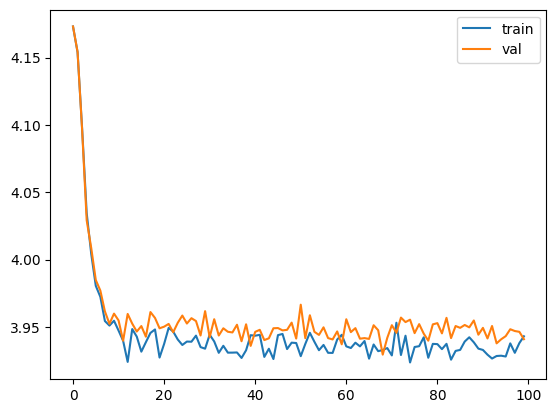

In [80]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10 
})
model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(
    model.parameters(), 
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    for epoch in range(config['epochs']):
        optimizer.zero_grad()
        
        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval'] :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

train(model, optimizer)

Notice how we get a training curve that goes down, but barely by anything. How do we know it's barely training? We have to use first principles. The cross-entropy loss before training is 4.17, and after 1000 epochs is 3.93. How can we make sense of it intuitively?

Cross-entropy in this context is referring to how likely we are to pick the wrong word. So here,

$$
H(T, q) = - \sum_{i = 1}^{N} \frac{1}{N} \log q(x_i)
$$

where $q(x_i)$ is the probability of picking the right word, as estimated by the model. If $q(x_i)$ is close to 1, then $\log q$ is close to 0; similarly, if $q$ is small, then $\log q$ is a large negative number, so $-\log q$ will be a large positive number. Now to build the intuition: to start, $-\log q = 4.17$, so $q = 0.015$, or around $\frac{1}{64.715}$. Recall that the vocabulary size $|V| = 65$, so what we're basically saying here is that the model is as good at choosing the next letter as randomly picking from our vocabulary. After training, $-\log q = 3.93$, so we're now basically choosing between 50 letters. This is a very small improvement, so something is probably wrong.

To get an intuition for how the loss relates to the model's performance, think about the model choosing among $\tilde V$ tokens; when $\tilde V$ is small, the model is more likely to guess right. In addition, we know $\max \tilde V = V$, which can help us understand if our model is learning at all.

$$\tilde V = \exp(L)$$

Let's try to debug what's going on. Notice that in our model we're using a softmax layer on our logits, which is a function that takes a vector of numbers and squashes them into a probability distribution. But for using the built in `F.cross_entropy` function, we need to pass in the [unnormalized logits directly](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html). So let's remove that from our model and try again.

model params: 33217
validation loss:  2.5100526332855226


<Axes: >

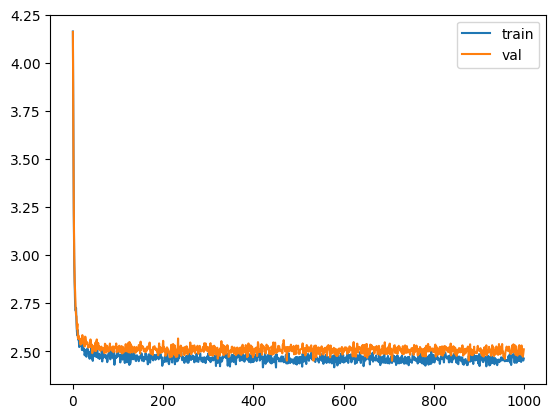

In [38]:
class SimpleModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Great, now our loss is $2.54$, so we're choosing from $12.67$ characters. That's way better than the 65 we started with. Let's add a generate method to our model so we visually see the results of our model.

In [39]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 1).long()
    for _ in range(max_new_tokens):
        # call the model
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[
            :, -1, :
        ]  # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)  # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )  # sample from the distribution to get the next token
        idx = torch.cat([idx, idx_next], dim=-1)  # append to the sequence
    return [decode(x) for x in idx.tolist()]

generate(model)

['\nAy:\nTI he st,\nFrd ucoirnd\nFute',
 "\nThieellainowhin'r 'tofail t Ju",
 '\n\nKIENIUK:\n\nBENCall ke pouth t ',
 '\n\nWillfel nthe, print ad mbuse?',
 '\nHARD o PUENo har\nTond towit mm']

It's not half bad, but also not half good. But now we have a working model that is training to a validation loss. So here we'll iterate on our model to make it closer to Llama.

## Llama specifics
Llama describes three architectural modifications to the original Transformer:
1. RMSNorm for pre-normalization
1. Rotary embeddings
1. SwiGLU activation function

We're going to add each one, one at a time to our base model, and iterate.

### RMSNorm

In Vaswani 2017, the original transformer uses BatchNormalization. In Llama, the authors use RMSNorm, which is where you scale the bector by the variance without centering it. In addition, while Vaswani applies normalization to the output of the attention layer (post-normalization), Llama applies it to the inputs before (pre-normalization).

In [40]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter("scale", nn.Parameter(torch.ones(layer_shape)))

    def forward(self, x):
        """
        assumes shape is (batch, seq_len, d_model)
        """
        # frob norm is not the same as RMS. RMS = 1/sqrt(N) * frob norm
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw

config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
m = RMSNorm((config['context_window'], config['d_model']))
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


We want to test to ensure that the RMSNorm is doing what we think it should. We can do this the old-fashioned way: row-wise comparisons. The RMSNorm has the property where the norm of the layer will be the square root of the number of elements in the layer, so we can check that for every layer.

In [41]:
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -.5)

# scaled_batch.var(dim=(1,2))
assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -.5)
assert torch.allclose(torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -.5

# RMS for sure
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

Alright, so that's RMSNorm, and it seems like it's working. Again, let's test it out.

model params: 35265
validation loss:  2.4489948749542236


<Axes: >

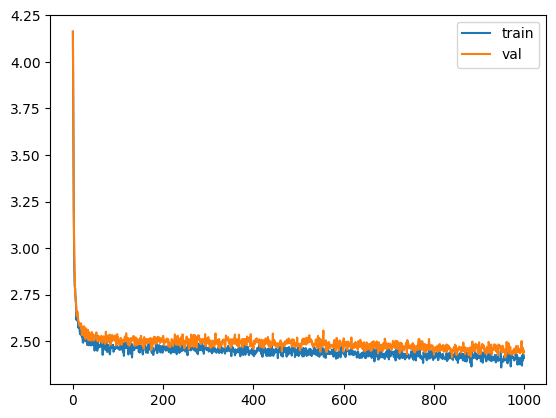

In [42]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x) # rms pre-normalization
        logits = self.linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = SimpleModel_RMS(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

So RMSNorm works, and it got our loss down by a small amount.

### Rotary Embeddings
[RoPE](https://arxiv.org/pdf/2104.09864.pdf) is a kind of positional encoding for transformers. In Attention is All You Need, the authors propose two kinds of positional encodings, learned and fixed. In RoPE, the authors propose embedding the position of a token in a sequence by rotating the embedding, with a different rotation at each position.

In [15]:
def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R

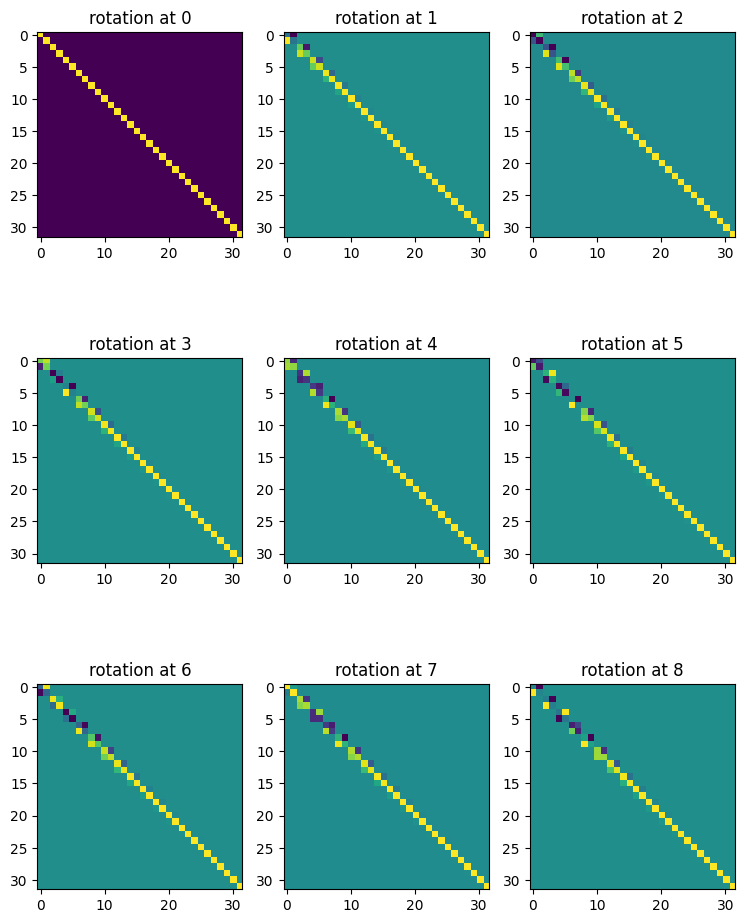

In [16]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j, :, :].detach().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

Let's make sure these work. They should exhibit the quality that 
$$
q_m^T k_n = (R^d_{\Theta, m}W_q x_m)^T (R^d_{\Theta, n} W_k x_n) = x^T W_q R^d_{\Theta, n-m} W_k x_n.
$$

In [43]:
config = {
    'd_model': 128,
    'context_window': 16,
}

R = get_rotary_matrix(config['context_window'], config['d_model'])
x = torch.randn(config['d_model'])
y = torch.randn(config['d_model'])

m = 3
n = 13

x_m = R[m,:,:] @ x
x_n = R[n,:,:] @ y

assert torch.isclose(x_m @ x_n, x @ R[n-m,:,:] @ y)

So the RoPE rotations work as expected.

In [44]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R)).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R)).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R)).transpose(0,1)

        activations, attn_weights = self.multihead(
            q,k,v, 
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

> Tip here: know the difference between tensor dimensions at train time vs tensor dimensions at inference time. 

Although at train time, you can expect your tensor dimensions to match your model parameters closely, eg `batch.shape = (config['batch_size'], config['context_window'], config['d_model'])`, at inference time, you may have to deal with a single example, eg `batch.shape = (1, 1, config['d_model'])`. For this reason, you need to make sure that when you're indexing in the `forward` pass, you're indexing using shapes derived from the input, not necessarily the model parameters.

Let's make sure it does what we think it does. For this layer, we're going to want to test three things:
1. that it rotates embeddings the way we think it does 
2. that the attention mask used for causal attention is working properly.

In [45]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(x)
k_rotated = torch.zeros_like(x)
v_rotated = torch.zeros_like(x)

for position in range(config['context_window']):
    q_rotated[:,position,:] = torch.matmul(q[:,position,:], layer.R[position,:,:])
    k_rotated[:,position,:] = torch.matmul(k[:,position,:], layer.R[position,:,:])
    v_rotated[:,position,:] = torch.matmul(v[:,position,:], layer.R[position,:,:])

q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [46]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttention(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m, :, :] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n, :, :] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k # transpose is redundant
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n, :, :].T @ layer.R[m, :, :] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m, :, :].T @ layer.w_q.weight @ x_q)

Now let's inspect the attention weights. Since this is causal, we would expect that due to masking, the upper triangular of the attention should be 0.

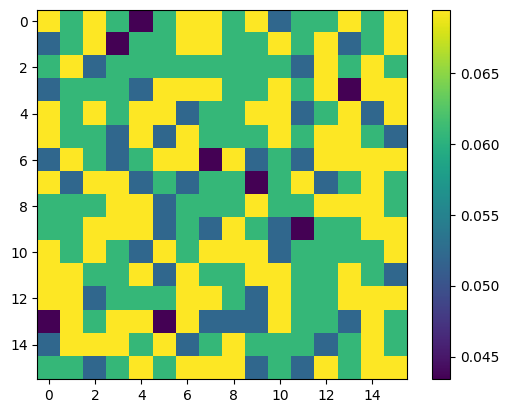

In [47]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy(), interpolation='nearest')
plt.colorbar()

This is not good; it means that information is leaking across the attention. We need to ensure the causal mask is working.

In [48]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim//2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i,2*i] = np.cos(m_theta)
                R[position, 2*i,2*i+1] = - np.sin(m_theta)
                R[position, 2*i+1,2*i] = np.sin(m_theta)
                R[position, 2*i+1,2*i+1] = np.cos(m_theta)
        return R
    
    def forward(self, x, return_attn_weights=False):
        b,m,d = x.shape
        
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q_out = (torch.bmm(q.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        k_out = (torch.bmm(k.transpose(0,1), self.R[:m, ...])).transpose(0,1)
        v_out = (torch.bmm(v.transpose(0,1), self.R[:m, ...])).transpose(0,1)

        causal_mask = torch.tril(torch.ones(m,m, requires_grad=False))
        activations, attn_weights = self.multihead(
            q,k,v, 
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m),
            is_causal=True
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

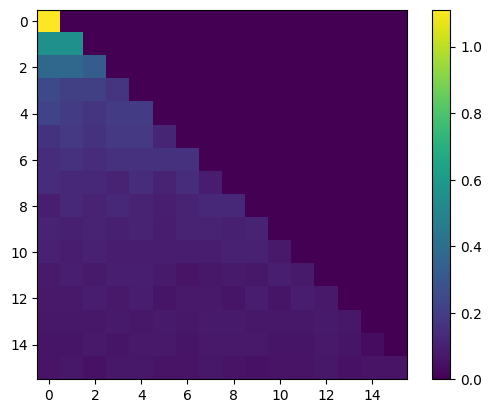

In [49]:
layer = RoPEAttention_wMask(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

Alright, let's run it and see what happens.

model params: 150465
validation loss:  1.9507311224937438


<Axes: >

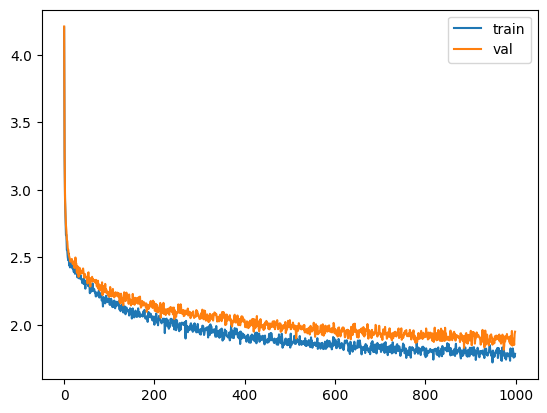

In [50]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

It looks like we can drive our loss down even lower. Let's do that by updating master config.

In [25]:
MASTER_CONFIG.update({
    "epochs": 2000,
    "log_interval": 10,
})

model params: 150465
validation loss:  2.168288516998291


<Axes: >

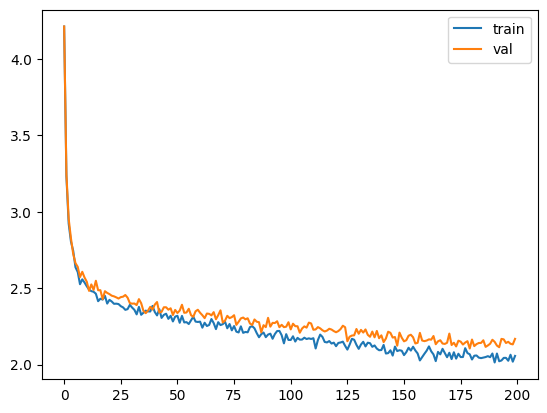

In [26]:
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

### SwiGLU

As it says in the paper, "We replace the ReLU non-linearity by the SwiGLU activation function...we use a dimension of $\frac{2}{3} 4d$ isntead of $4d$ as in PaLM." SwiGLU is defined as:
$$ 
\text{SwiGLU}(x) = \text{Swish}_\beta (xW + b) \otimes (xV + c)
$$
where $\otimes$ is a component-wise product. The Swish function is defined as:
$$
\text{Swish}_\beta(x) = x \sigma(\beta x)
$$
where $\beta$ is a learnable parameter.

In [27]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter("beta", self.beta)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 183490
validation loss:  2.1011534452438356


<Axes: >

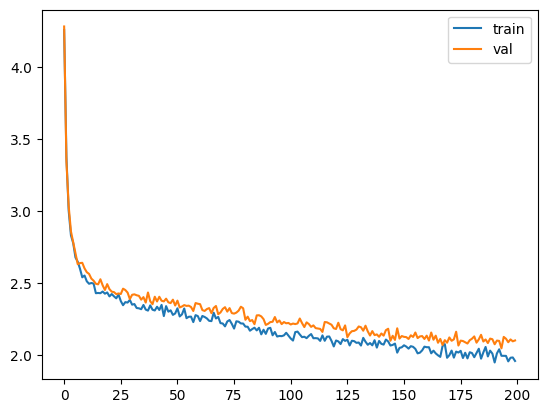

In [28]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])
        
        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        
        # one block of attention
        x = self.rms(x) # rms pre-normalization
        x = x + self.rope_attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

        else:
            return logits

model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

Now, let's add multiple layers of RopeAttention by creating blocks.

In [29]:
# add RMSNorm and residual conncection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.rms = RMSNorm((config['context_window'], config['d_model']))
        
        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

In [31]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']));

model params: 733382
validation loss:  1.8632867693901063


<Axes: >

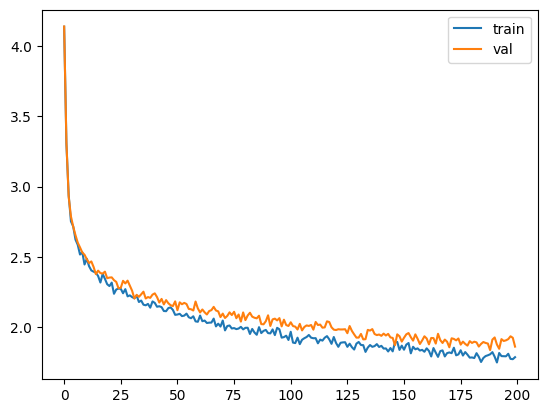

In [33]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embeddings = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embeddings(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss

llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, MASTER_CONFIG)

It looks like we can drive the loss down even more, and although we're overfitting a little, I think we can still do better. Let's train longer.

validation loss:  1.0796078860759735


<Axes: >

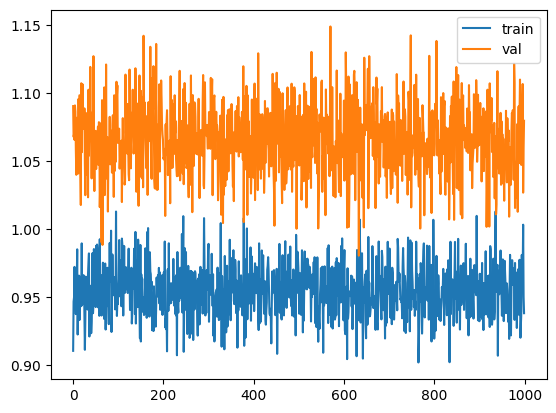

In [94]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

It seems we can go even lower, still without serious overfitting. Either there is a leak, or it's actually doing well. The loss here is 1.08, which is equivalent to choosing between 2.9 tokens randomly.

validation loss:  1.0959919810295105


<Axes: >

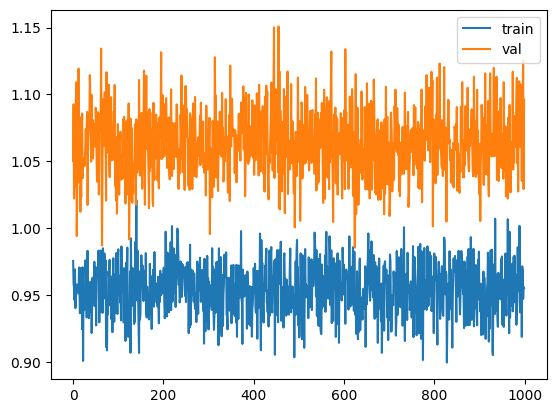

In [51]:
train(llama, optimizer, MASTER_CONFIG)

In [55]:
print(generate(llama, MASTER_CONFIG, 500)[0])


That what swas widep to &neder theep save life
Hem,
Morecon! Is from, an go thinks of which with I'?

Old Marciush, thus, i'll drawnt we'll an that be Callay,
So, leartet,
So swomet

You is gicfevers,
Ind law I drult I compland--Pair: the love boe salithese;
Forole:
I doth not they, you advinest's pared, ah, by: dark, you thy liord underanus's the vily:
 onever of romb't and vust both though,
loade wath you'll, eself sway mishty would.

Peace
FRARD:
Now, gorse:
Who I mall to nued, should sould.



At this point, we've hit the bottom with our training.

# Miscellaneous

## Check for Gradient Flows

Let's inspect the gradients, we want to see how they're flowing. If there are too many gradients where the value is close to 0, that's a problem.

In [88]:
# print the percentage that are near 0
def show_grads(model, tol=1e-2):
    return sorted([(name, 100.0 * float(torch.sum(torch.abs(param) <= tol)) / float(param.nelement())) for name, param in model.named_parameters() if param.requires_grad], key=lambda t: t[1], reverse=True)

show_grads(llama)

[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 38.020833333333336),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 37.760416666666664),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 36.979166666666664),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 35.9375),
 ('llama_blocks.llama_0.attention.multihead.in_proj_weight', 16.510009765625),
 ('llama_blocks.llama_0.attention.w_q.weight', 13.07373046875),
 ('llama_blocks.llama_0.attention.multihead.out_proj.weight', 12.548828125),
 ('llama_blocks.llama_0.attention.w_k.weight', 12.3779296875),
 ('llama_blocks.llama_1.attention.w_v.weight', 11.822509765625),
 ('llama_blocks.llama_1.attention.multihead.out_proj.bias', 11.71875),
 ('llama_blocks.llama_2.attention.w_v.weight', 11.651611328125),
 ('llama_blocks.llama_1.attention.multihead.out_proj.weight', 11.6455078125),
 ('llama_blocks.llama_1.attention.multihead.in_proj_weight',
  11.191813151041666),
 ('llama_blocks.llama_0.attention.w_v.weight'

Here, for all of our parameter gradients, the vast majority are non-zero, which is great. If we start to see this number peak higher, then our gradients would not be flowing.

## Experiment with hyperparams, aka "change the oven settings"

In the original Llama paper, the authors use Cosine Annealing learning schedule. We didn't do that here, because I experimented and saw that it was worse. 

model params: 733382


/Users/bkitano/Desktop/projects/llama/.llama/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:814: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


lr:  [0.0009999457184159408]
lr:  [0.0009961510274583004]
lr:  [0.0009869757772816292]
lr:  [0.0009725204933511963]
lr:  [0.0009529435502760634]
lr:  [0.0009284594366176498]
lr:  [0.0008993364049014041]
lr:  [0.0008658935325782156]
lr:  [0.0008284972261358946]
lr:  [0.0007875572066618724]
lr:  [0.0007435220208394261]
lr:  [0.0006968741265588948]
lr:  [0.0006481246069855613]
lr:  [0.0005978075709959357]
lr:  [0.0005464743013294258]
lr:  [0.0004946872145648923]
lr:  [0.00044301369909075325]
lr:  [0.00039201989856974814]
lr:  [0.0003422645089892466]
lr:  [0.0002942926572257539]
lr:  [0.0002486299281339155]
lr:  [0.0002057766054928797]
lr:  [0.00016620218969383484]
lr:  [0.00013034025177986015]
lr:  [9.858367916643242e-05]
lr:  [7.128036241775617e-05]
lr:  [4.872936226262451e-05]
lr:  [3.117756953567661e-05]
lr:  [1.8816750064937722e-05]
lr:  [1.1779739336260682e-05]
lr:  [1.0054282328142978e-05]
lr:  [1.396862020283371e-05]
lr:  [2.3138198807489664e-05]
lr:  [3.7591595433673565e-05]
lr:  

<Axes: >

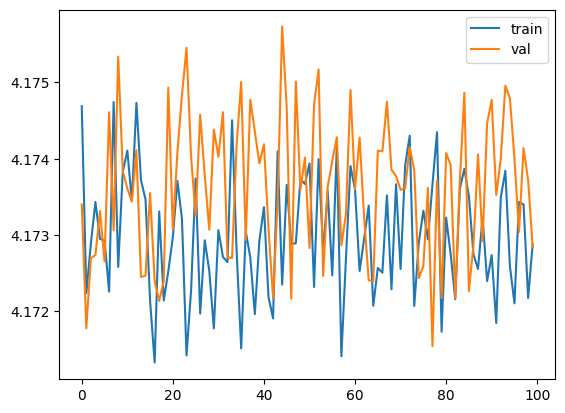

In [92]:
MASTER_CONFIG.update({
    "epochs": 1000
})
llama_with_cosine = Llama(MASTER_CONFIG)
llama_optimizer = torch.optim.Adam(
    llama.parameters(), 
    betas=(.9, .95), 
    weight_decay=.1, 
    eps=1e-9, 
    lr=1e-3
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(llama_optimizer, 300, eta_min=1e-5)
train(llama_with_cosine, llama_optimizer, scheduler=scheduler)

In [93]:
show_grads(llama_with_cosine, 1e-5)

[('llama_blocks.llama_0.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_0.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_1.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_2.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.in_proj_bias', 100.0),
 ('llama_blocks.llama_3.attention.multihead.out_proj.bias', 100.0),
 ('llama_blocks.llama_2.attention.w_v.weight', 0.030517578125),
 ('llama_blocks.llama_0.attention.w_k.weight', 0.0244140625),
 ('llama_blocks.llama_0.feedforward.1.linear.weight', 0.0244140625),
 ('llama_blocks.llama_2.attention.multihead.out_proj.weight', 0.0244140625),
 ('llama_blocks.llama_0.attention.w_v.weight', 0.018310546875),
 ('llama_blocks.llama_2.attention.w_q.weight', 0.018310546875),
 ('llama_blocks.llama_0.feedforward.0.weight', 0.01220703125

Even at an extremely low tolerance, the attention biases are not getting any signal. I'm not sure why the learning schedule from the paper doesn't work, but the lesson here is simple: start simple.

# Takeaways

## Always work iteratively: start small, stay certain, and build up.
My approach for implementing papers is:
1. Make all of the helper functions required to test your model quantitatively (data splits, training, plotting the loss).
1. Before you even look at the paper, pick a small, simple, and fast model that you've done in the past. Then make a helper function to evaluate the model qualitatively.
1. Start by picking apart different components of the paper, and then implementing them one-by-one, training and evaluating as you go.

## Make sure your layers do what you think.
1. Use `.shape` religiously.
1. Work out the results without matrix multiplication first, and then use the `torch` functions to make it efficient after.
1. Have a test to see that your layer is right. For example, the RoPE embeddings have a specific property that you can test for. For the Transformer, you can test that the attention is working by looking at the attention map.
1. Test your layers on various batch, sequence, and embedding sizes. Even if it works for one size, it might not work for others, which will cause problems at inference time.
